# Get required inputs
We build the design matrix and contrast (used to get the F threshold later), and load the F-statistic map. 

In [1]:
import glob
import re
import pandas as pd
import numpy as np
import nibabel as nib

factor_maps_out = "/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/output_surveyMedley_noderivs_rerun/factor_weighted_averages"
bold_files = glob.glob(f"{factor_maps_out}/*")
num_factors = 6
sub_ids = sorted(set([re.search('_sub_(.*).nii.gz', val).group(1) for val in bold_files]))

sorted_bold_files = []
for sub in sub_ids:
    for i in range(num_factors):
        sorted_bold_files.append(f"{factor_maps_out}/factor_{i+1}_weighted_avg_sub_{sub}.nii.gz")

design_matrix = pd.DataFrame()
# First 5 columns are dummy regressors for factors 2-6
one_indices = []
for i in range(len(sub_ids)):
    one_indices.append(1 + num_factors * i)
for i in range(num_factors - 1):
    one_indices_updated = [x + i for x in one_indices]
    col = [1 if j in one_indices_updated else 0 for j in range(len(sorted_bold_files))]
    design_matrix[f"factor_{i + 2}"] = col
# The other 66 columns are dummy regressors for each subject
one_indices = [0, 1, 2, 3, 4, 5]
for i in range(len(sub_ids)):
    one_indices_updated = [x + num_factors * i for x in one_indices]
    col = [1 if j in one_indices_updated else 0 for j in range(len(sorted_bold_files))]
    design_matrix[sub_ids[i]] = col

contrast = np.zeros((5, 71)) 
contrast[:, 0:5] = np.eye(5)

f_stat_map = nib.load("/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/output_surveyMedley_noderivs_rerun/factor_f_test_output/factor_maps_f_test_f_stat.nii.gz")

# Get clusters and make a label map of above-threshold clusters

In [2]:
from scipy.stats import f
from nilearn.reporting import get_clusters_table

# Degrees of freedom
df_num = contrast.shape[0]
df_den = design_matrix.shape[0] - design_matrix.shape[1]

# F threshold for p = 0.0005 (right-tail)
f_p_0005 = f.isf(0.0005, df_num, df_den)

cluster_table, cluster_label_maps = get_clusters_table(
    stat_img=f_stat_map,
    stat_threshold=f_p_0005,   # F-stat threshold
    cluster_threshold=100,     # min cluster size in voxels (set >0 to filter)
    two_sided=False,            # F-tests are always positive
    min_distance=500,
    return_label_maps=True
)
cluster_table

Cluster ID          X          Y          Z  Peak Stat  Cluster Size (mm3)
0            1  -8.499998 -90.699999  -3.699998  51.638135               76857
1            2 -32.699999  34.700004 -10.299999  22.425843               55657
2            3 -17.299998  39.100004  51.300003  18.477723               29516
3            4  37.700003   8.300003  29.300002  15.585586                9764
4            5  35.500003 -40.099998 -12.499999  13.163657                3641
5            6 -39.299999 -29.099998  53.500003  12.771227                4791
6            7  33.300003  23.700003  -3.699998  12.037424                2055
7            8 -54.699999 -53.299998  18.300002  10.696910                1937
8            9  -6.299998 -57.699998  16.100002   9.916565                2512
9           10  48.700003 -15.899997 -10.299999   9.910883                1490
10          11   9.100002 -57.699998  57.900003   8.686128                1086
11          12  11.300002 -66.499999  40.300003   8.586390                4408
12          13  50.900003  12.700003 -21.299999   8.453664                1245
13          14  39.900003 -18.099998  16.100002   8.409142                2470
14          15  42.100003 -51.099998  35.900002   7.872465                3460
15          16  55.300003   8.300003   5.100002   7.834440                1874

# Plot figures

In [3]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step 1: Load cluster mask
cluster_img = cluster_label_maps[0]
cluster_data = cluster_img.get_fdata()
cluster_labels = np.unique(cluster_data)
cluster_labels = cluster_labels[cluster_labels != 0]  # exclude background

# Step 2: Extract subject IDs and factor names
subject_ids = []
factors = []
for fp in sorted_bold_files:
    # Extract subject ID between 'sub_' and '.nii.gz'
    sub_match = re.search(r"sub_([^/]+)\.nii\.gz", fp)
    subject_id = sub_match.group(1) if sub_match else "unknown"
    subject_ids.append(subject_id)

    # Extract factor name 
    base = os.path.basename(fp)
    f_match = re.match(r"(.*)_weighted_avg", base)
    factor = f_match.group(1) if f_match else "unknown"
    factors.append(factor)

subject_ids = np.array(subject_ids)
factors = np.array(factors)

# Step 3: Extract mean BOLD signals per cluster per file
masker = NiftiLabelsMasker(labels_img=cluster_img, standardize=False)
bold_by_cluster = masker.fit_transform(sorted_bold_files)
# shape: (n_files, n_clusters)

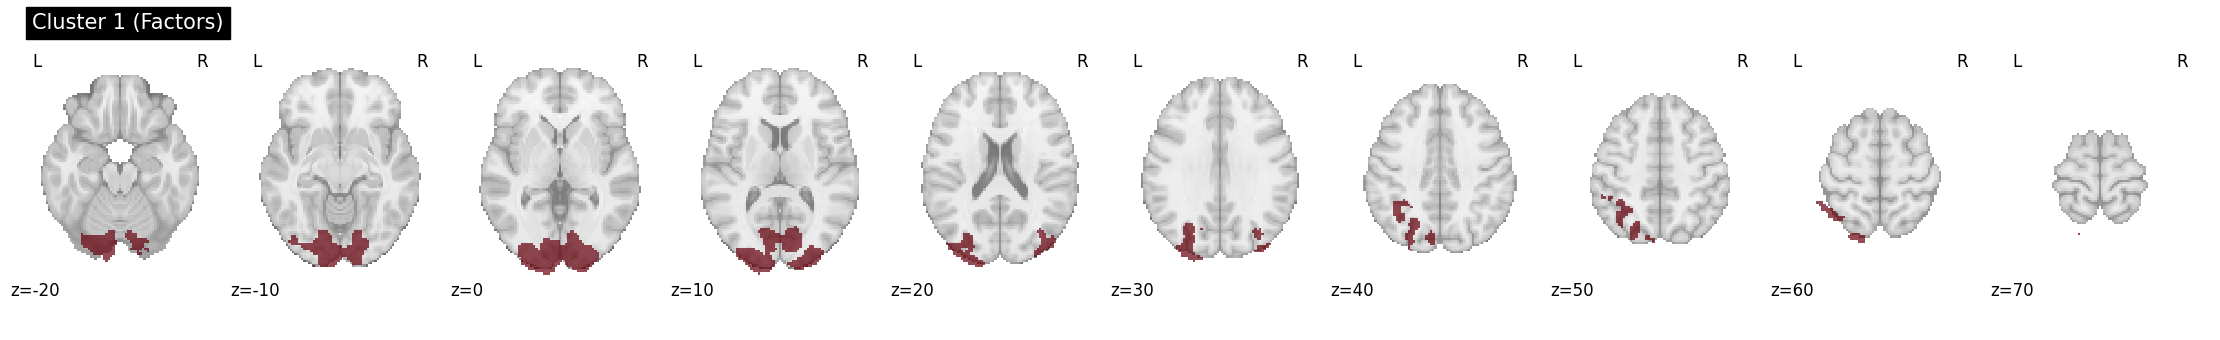

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

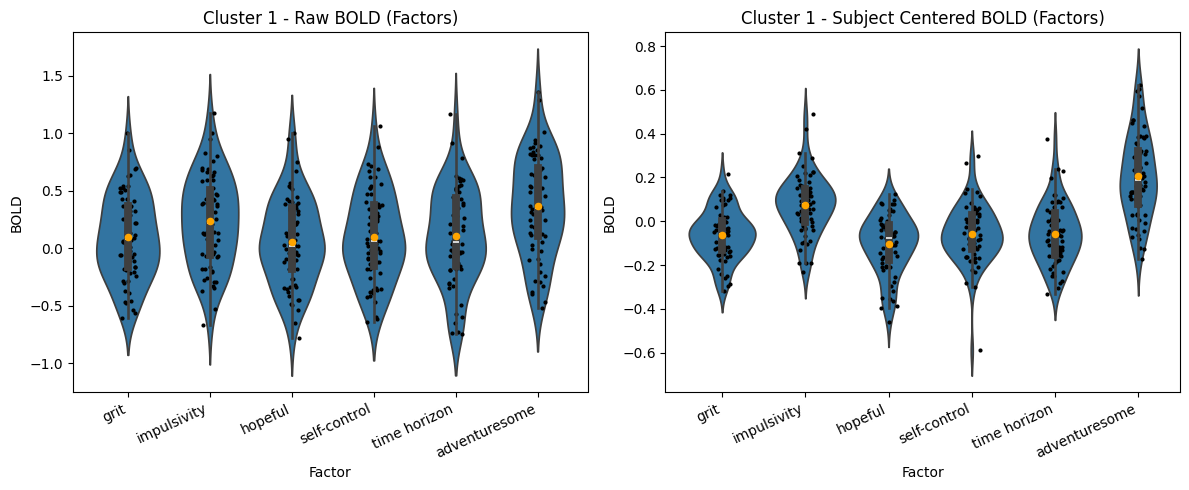

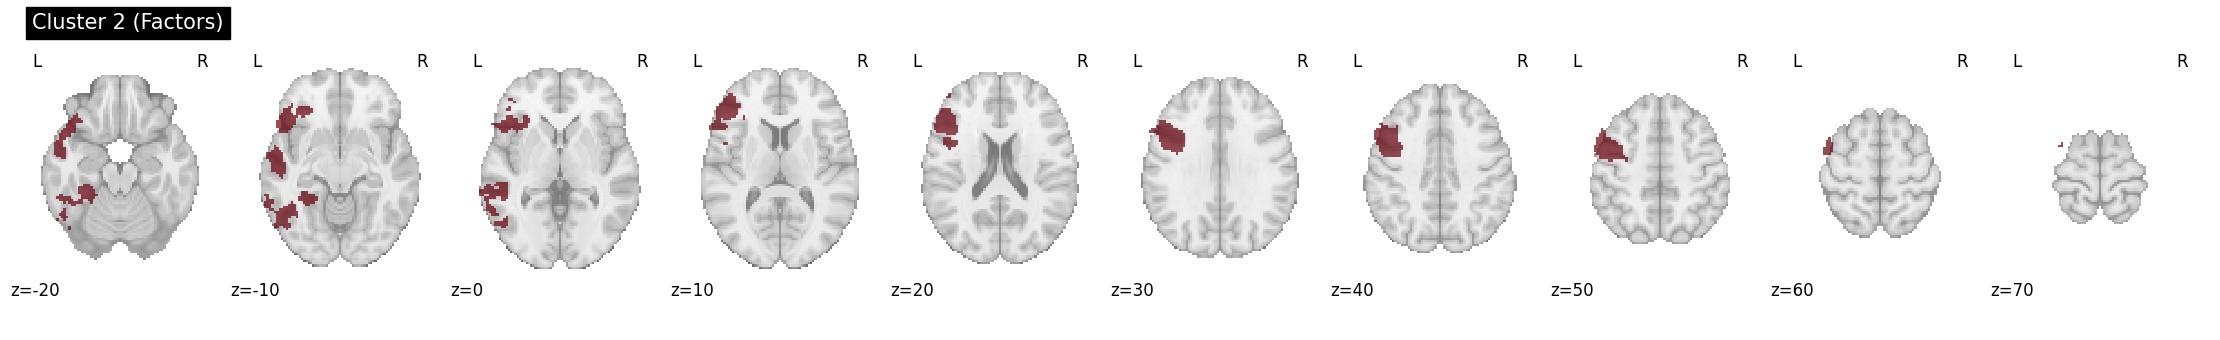

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

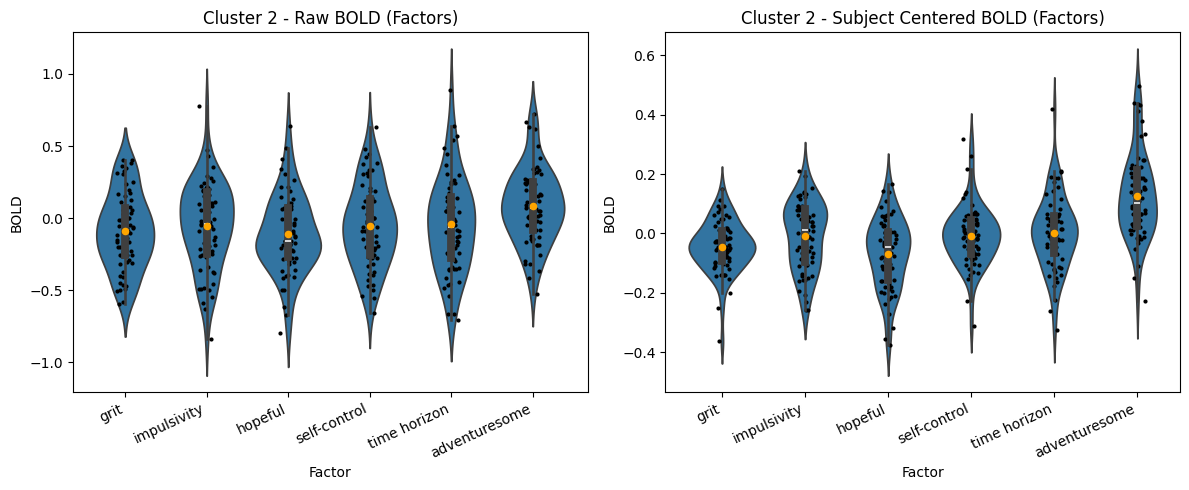

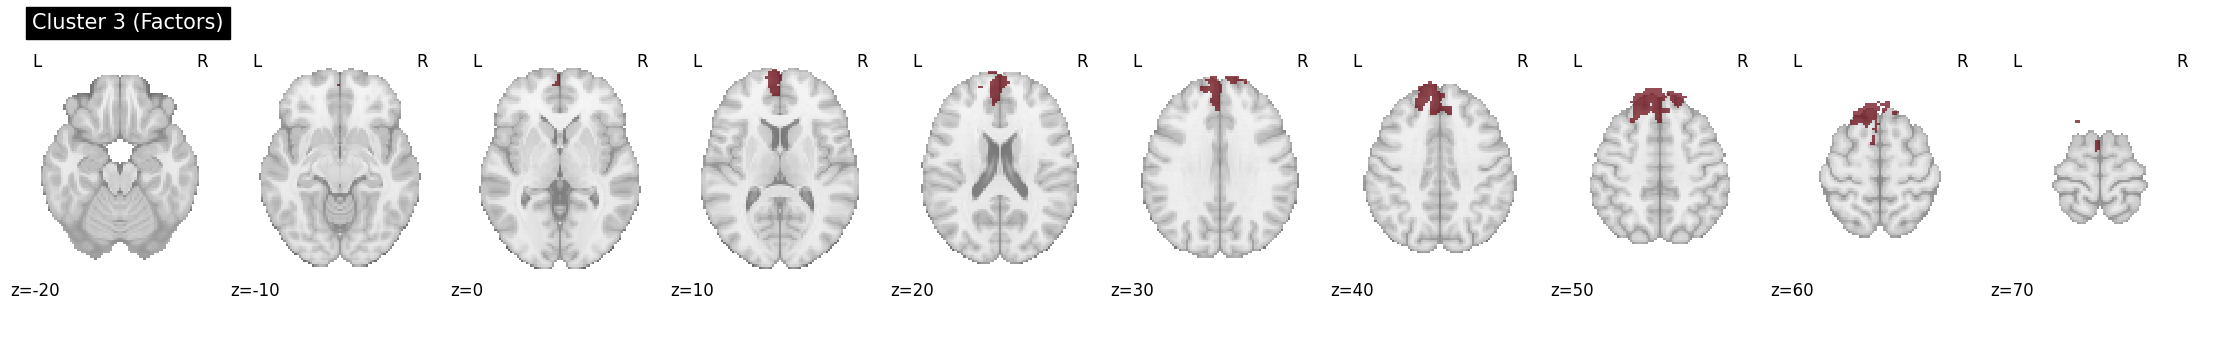

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

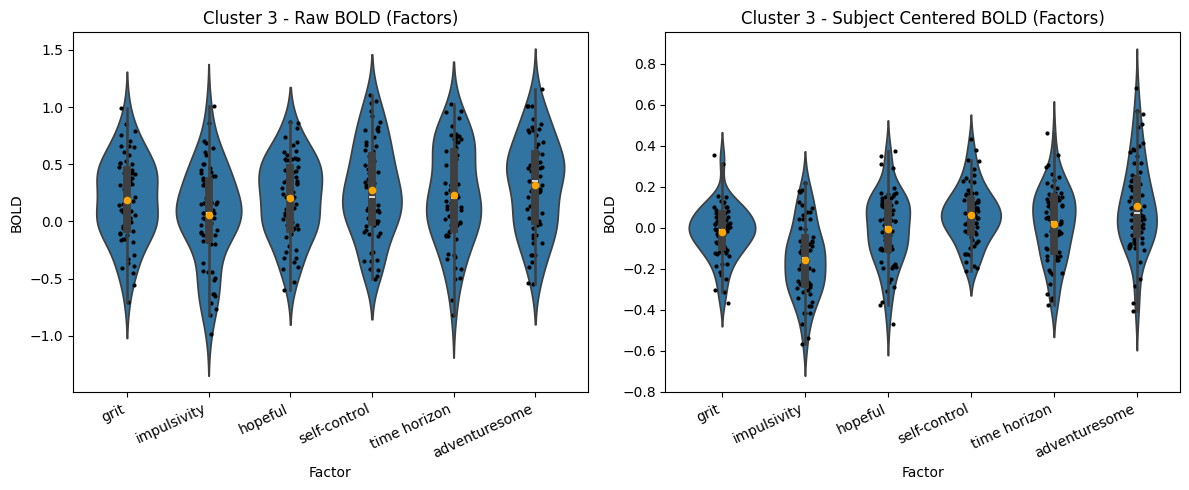

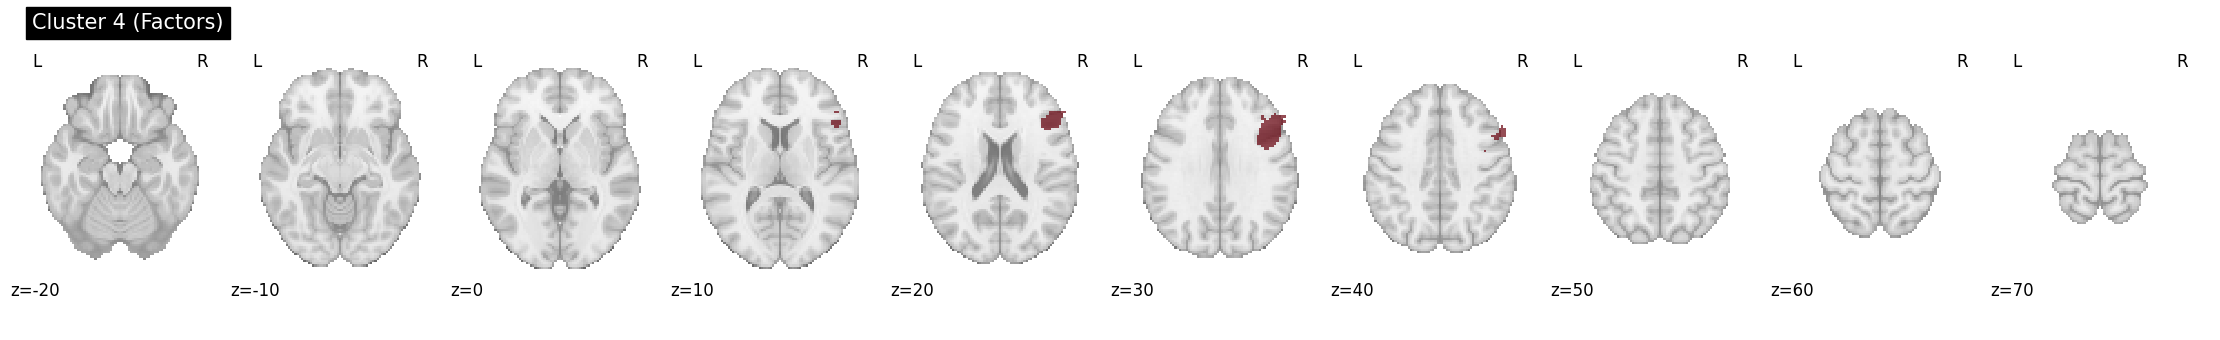

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

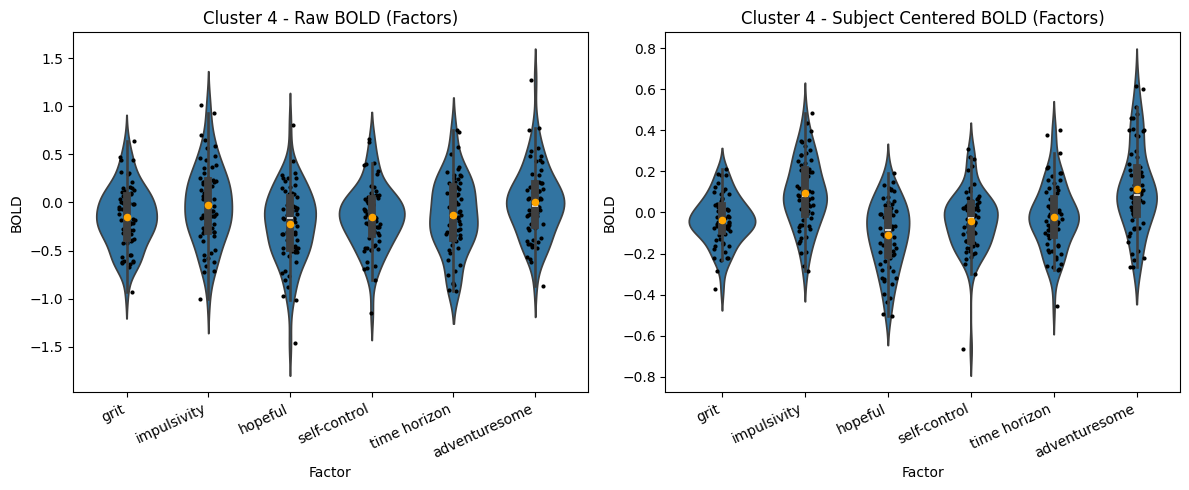

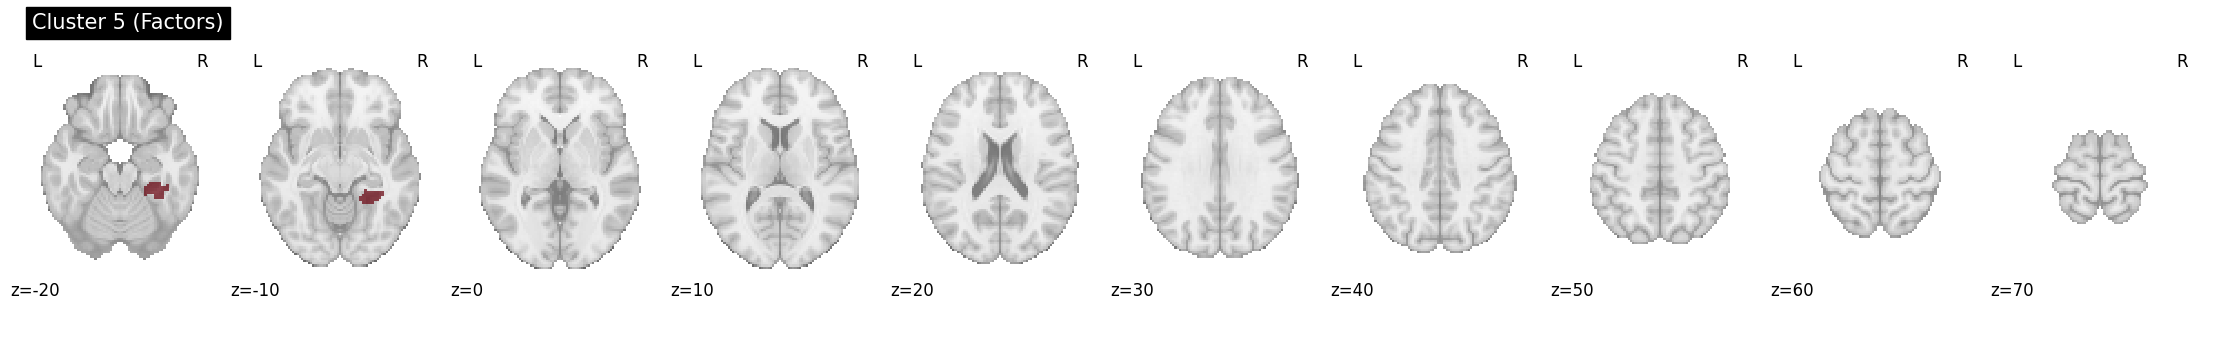

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

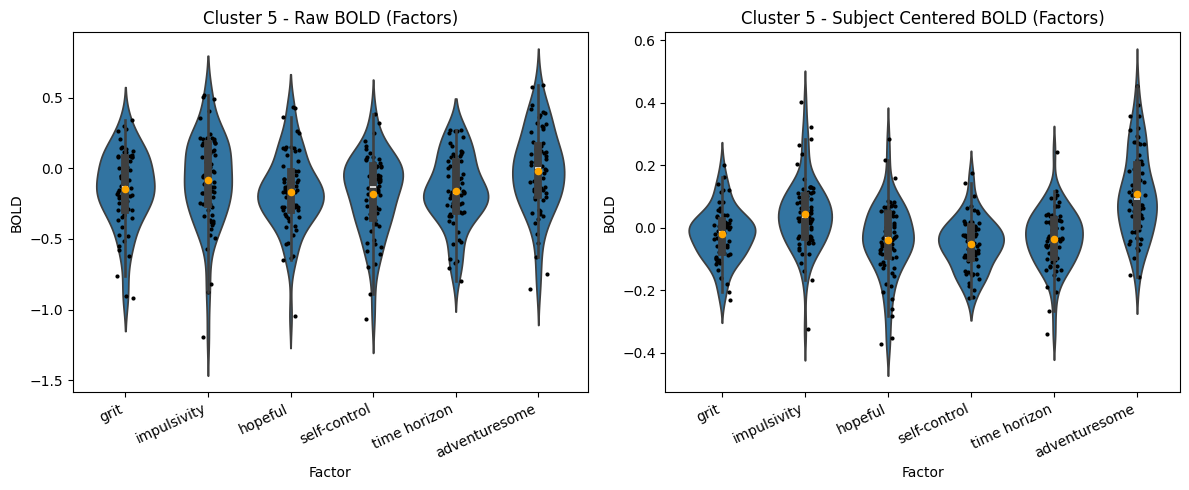

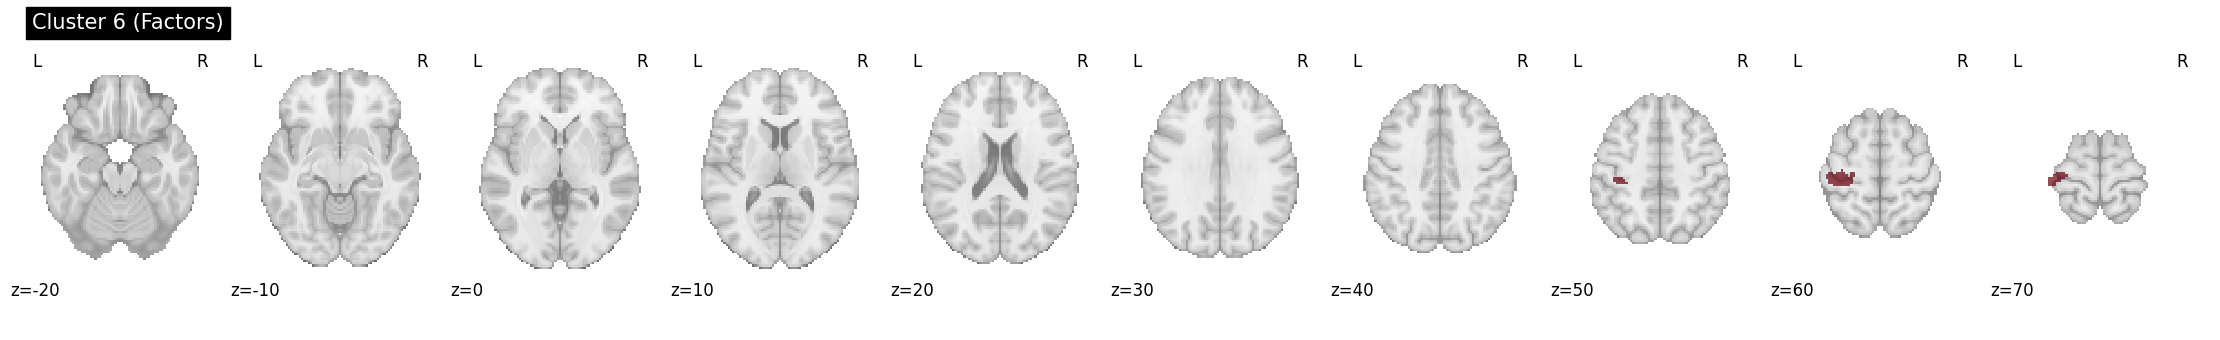

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

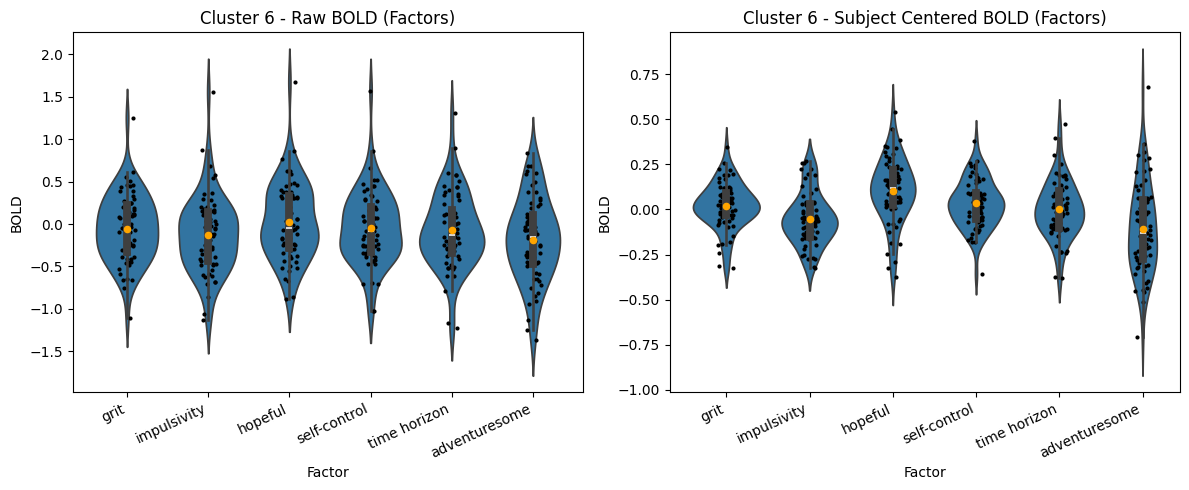

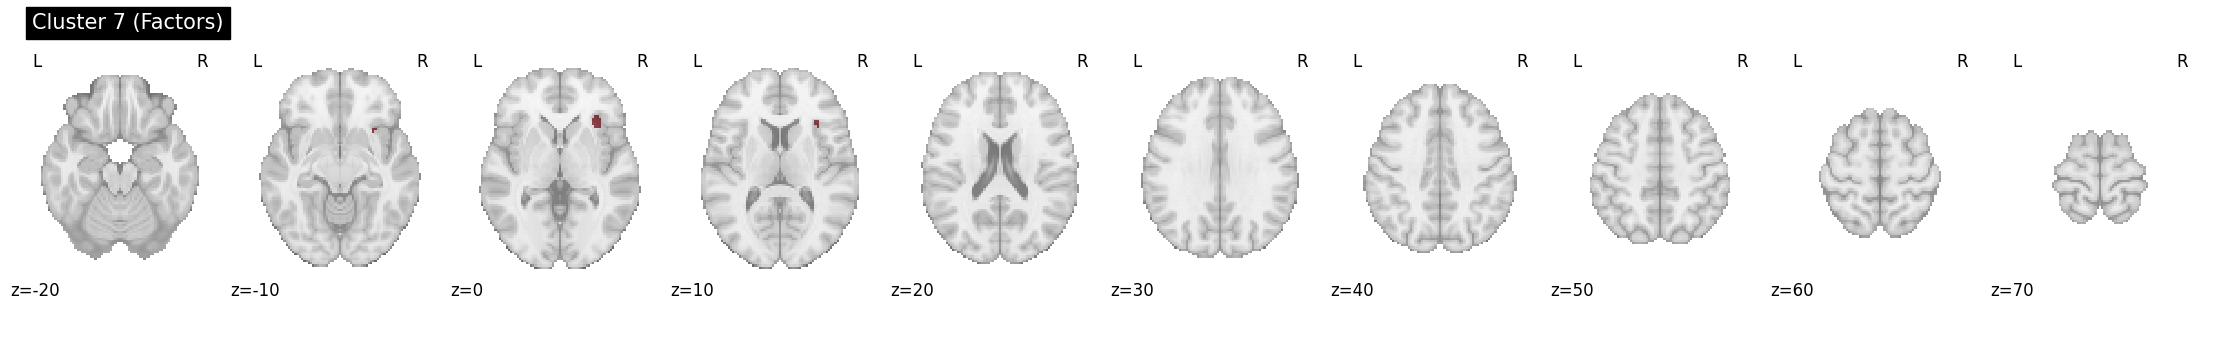

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

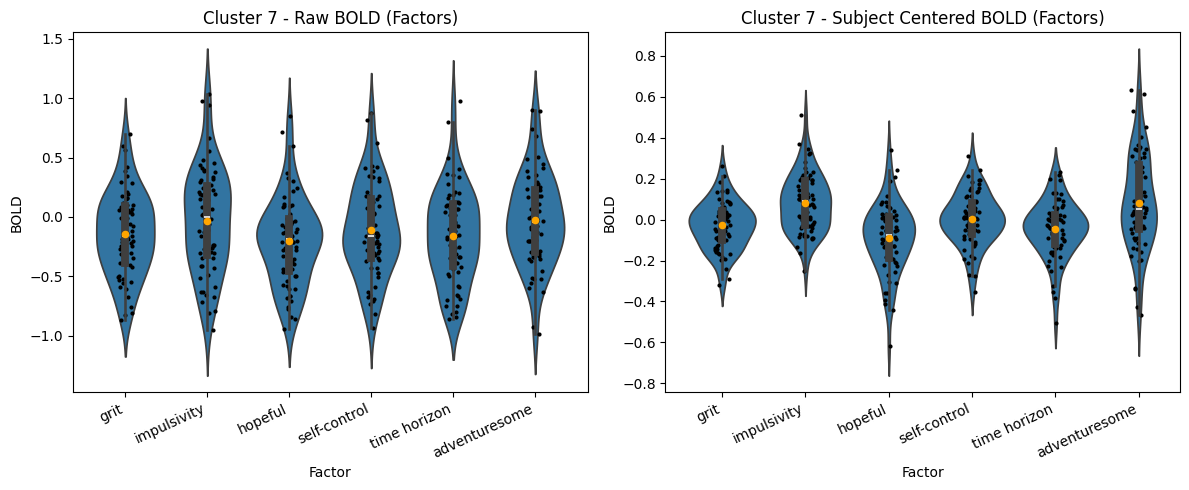

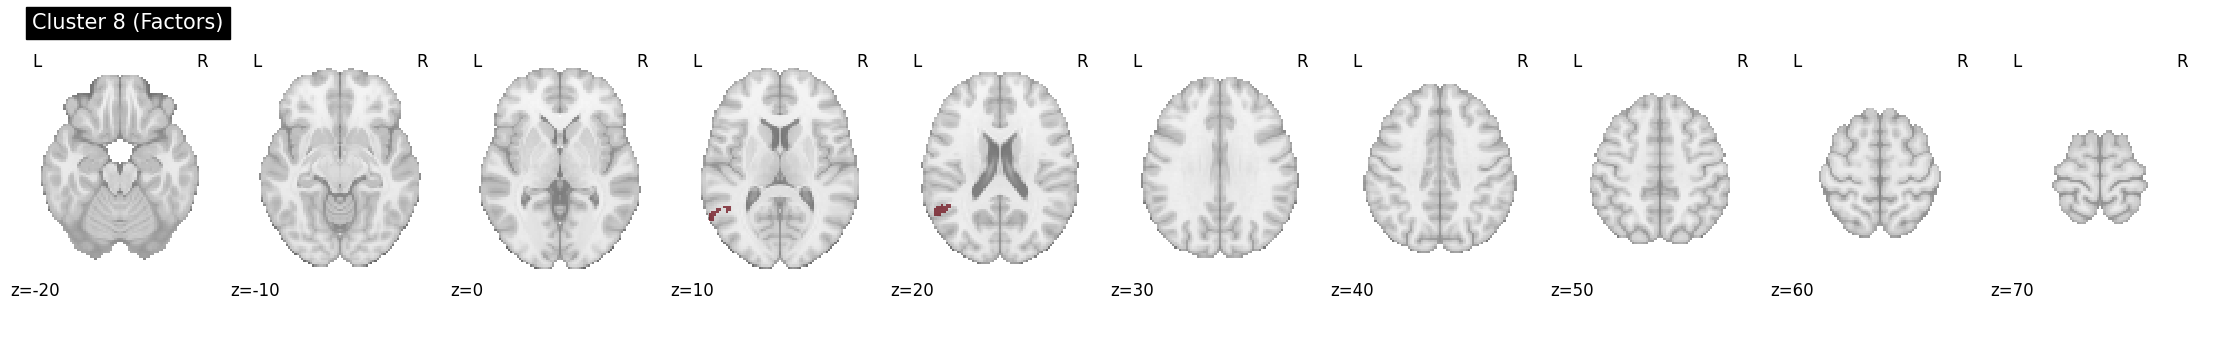

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

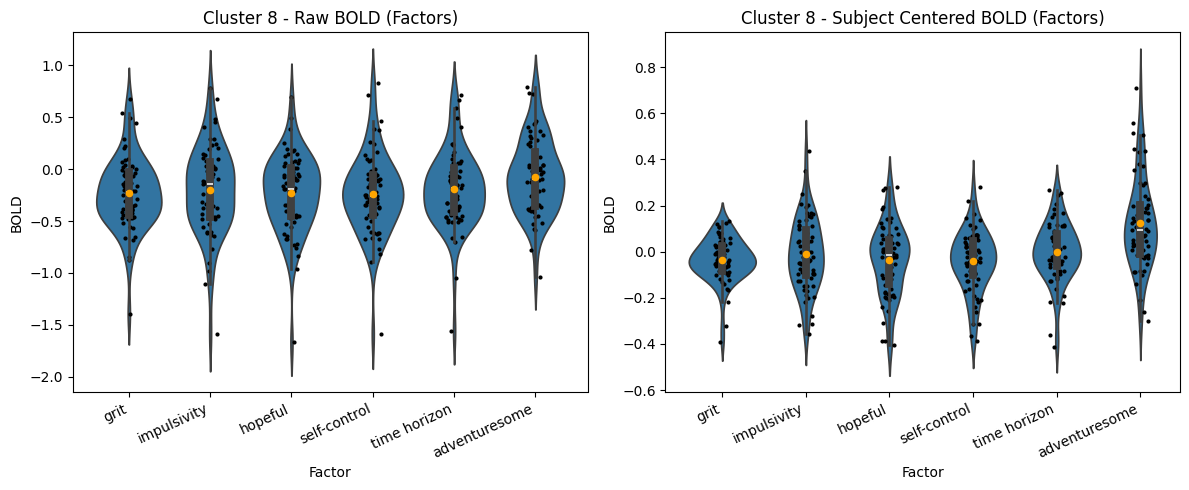

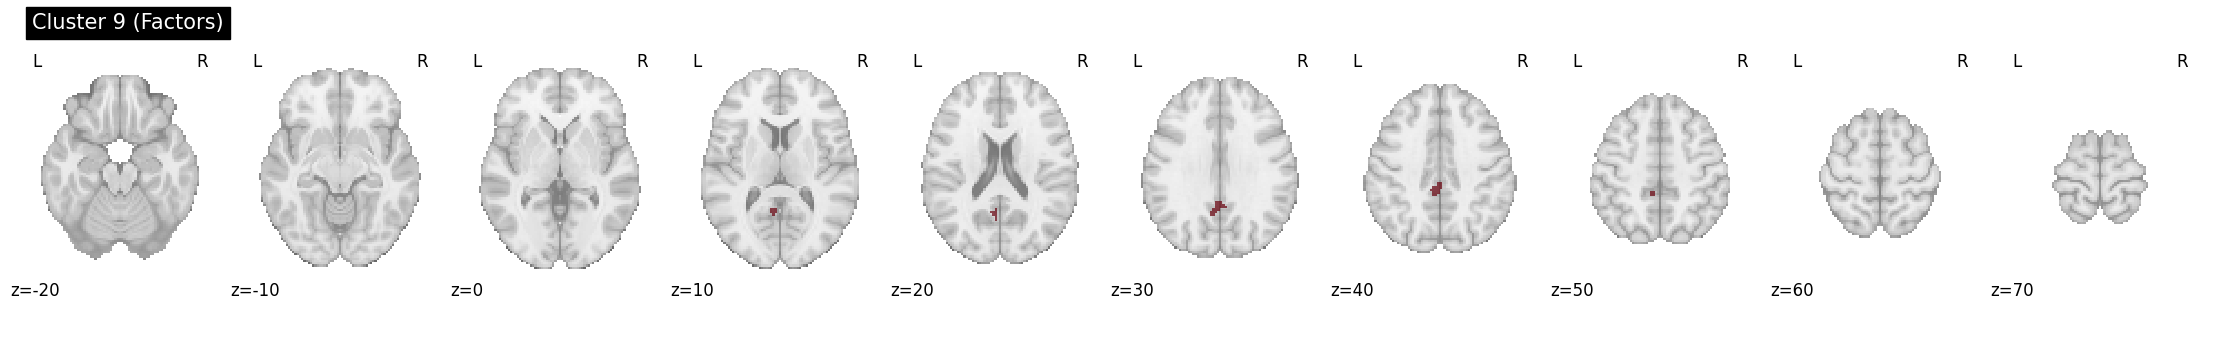

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

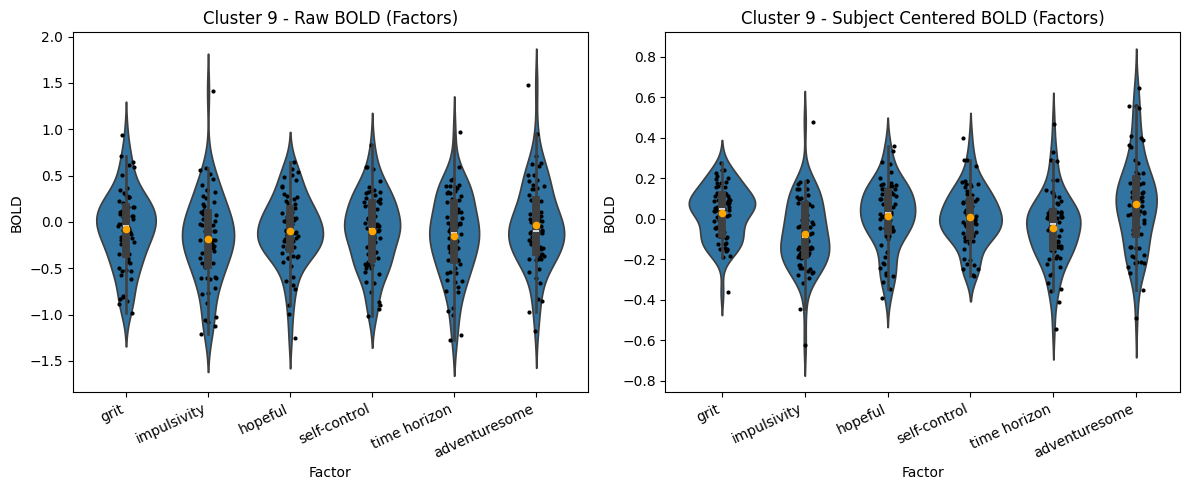

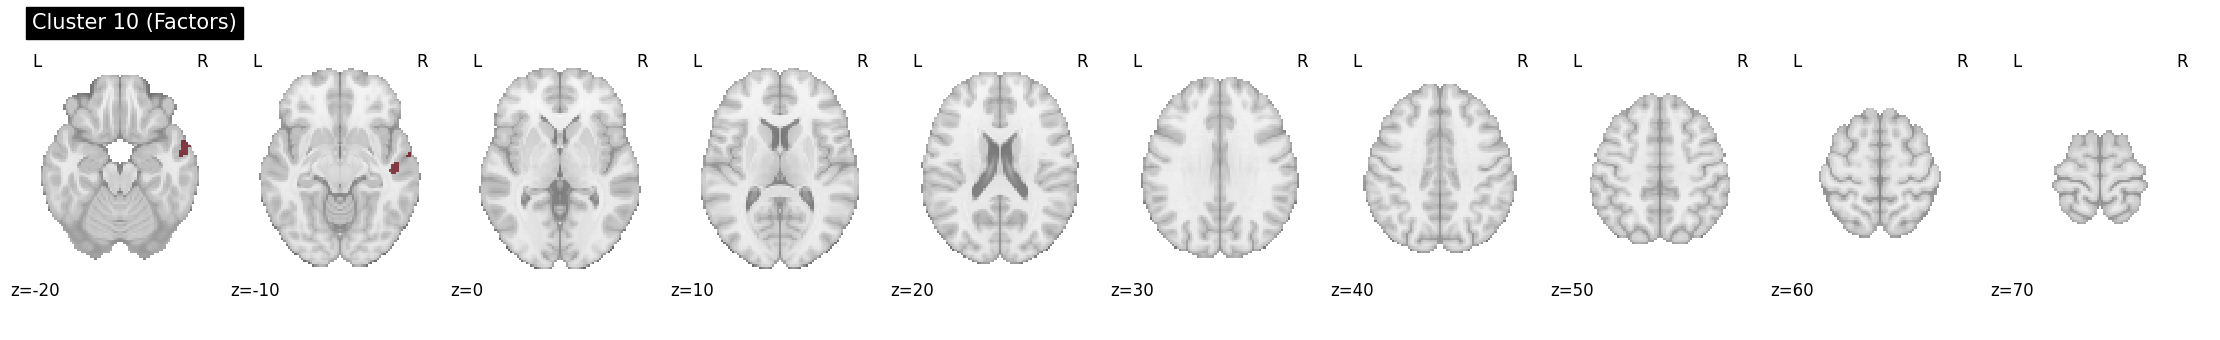

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

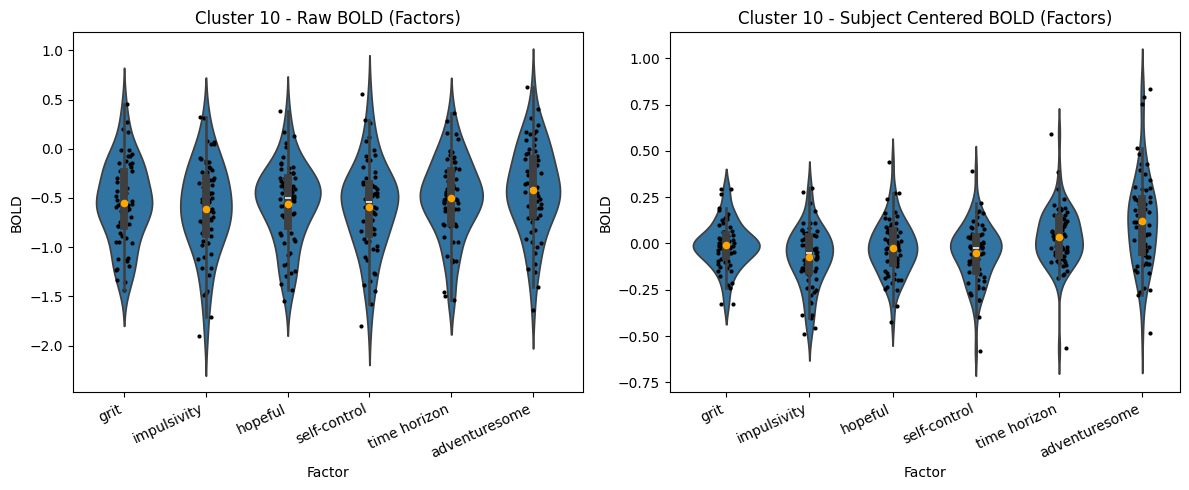

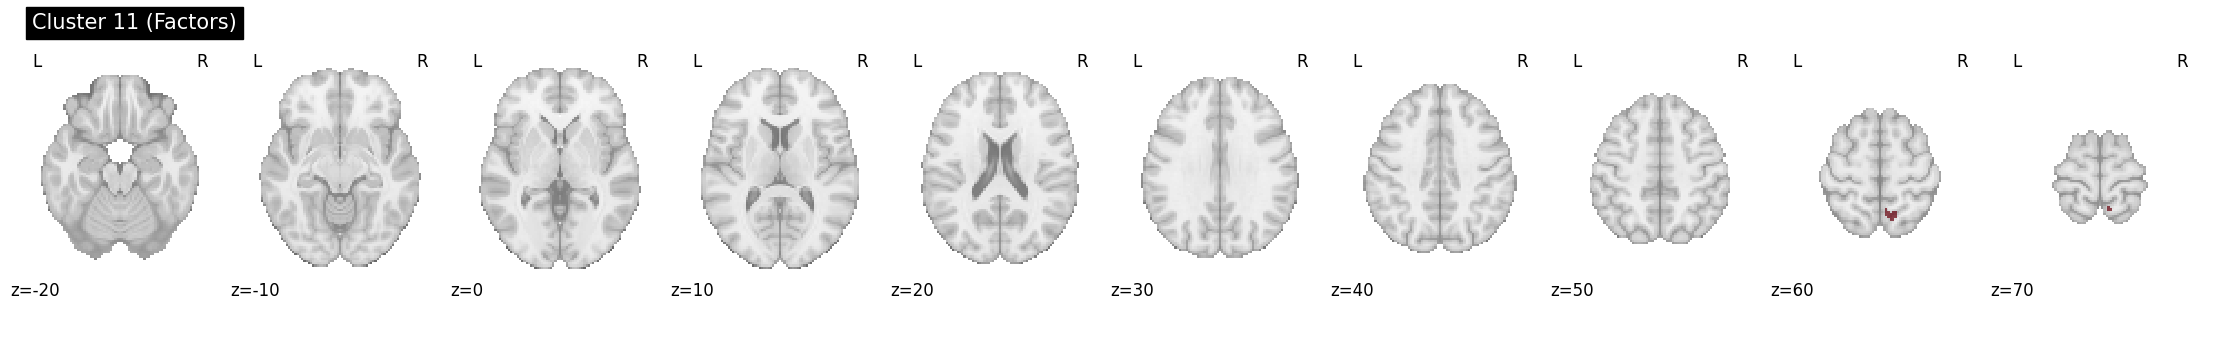

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

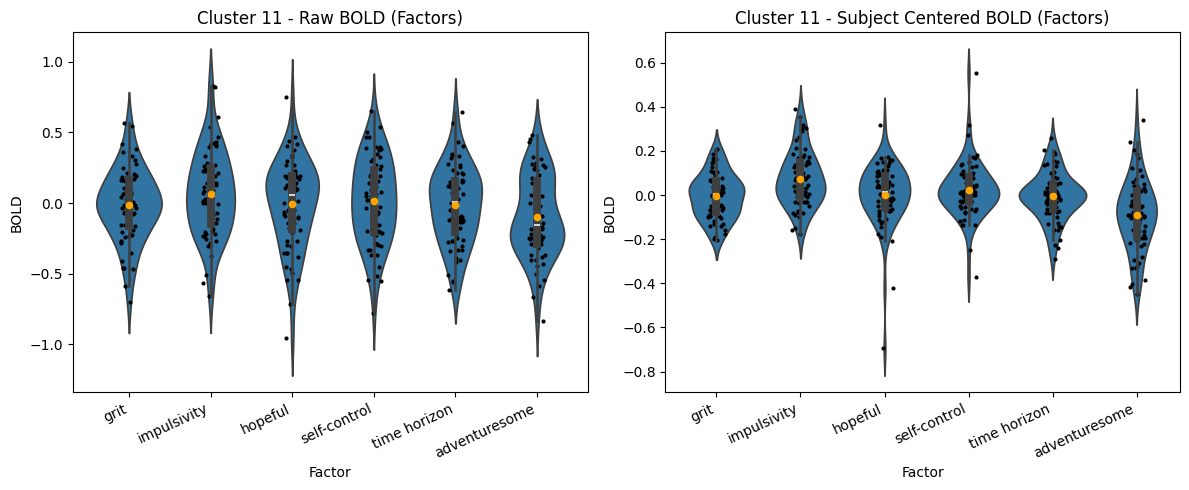

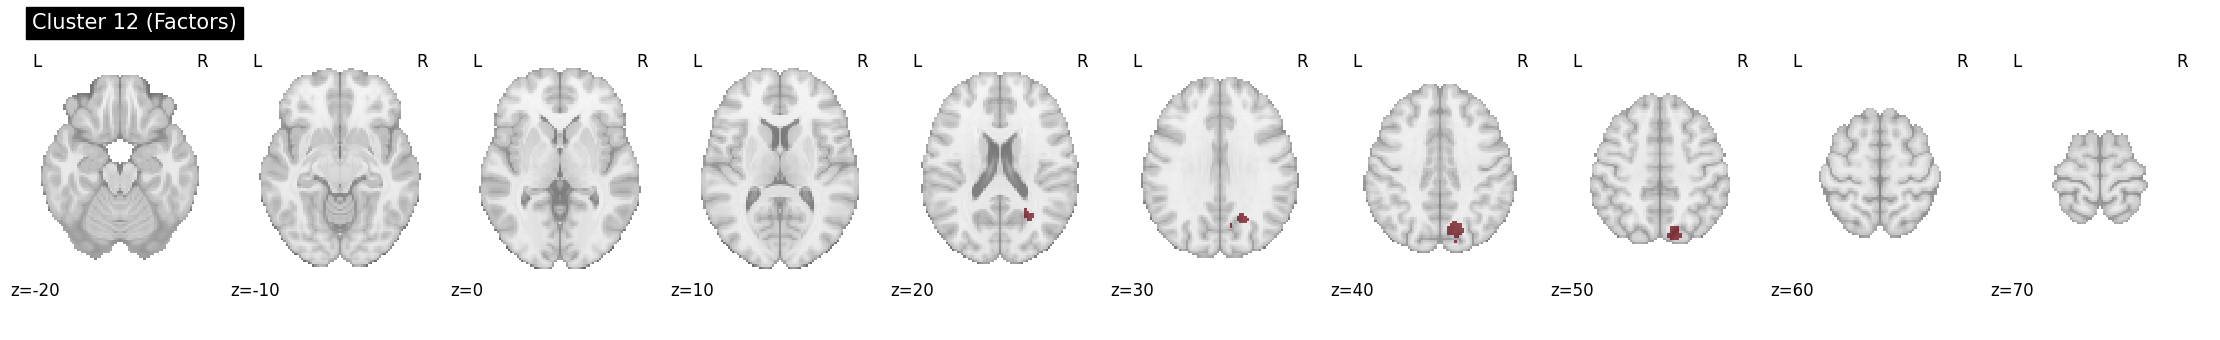

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

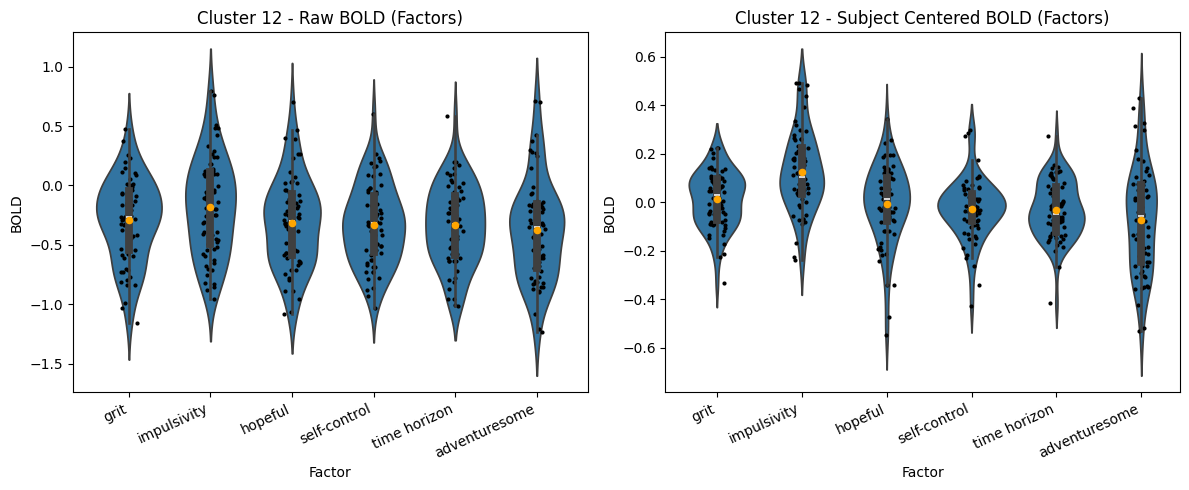

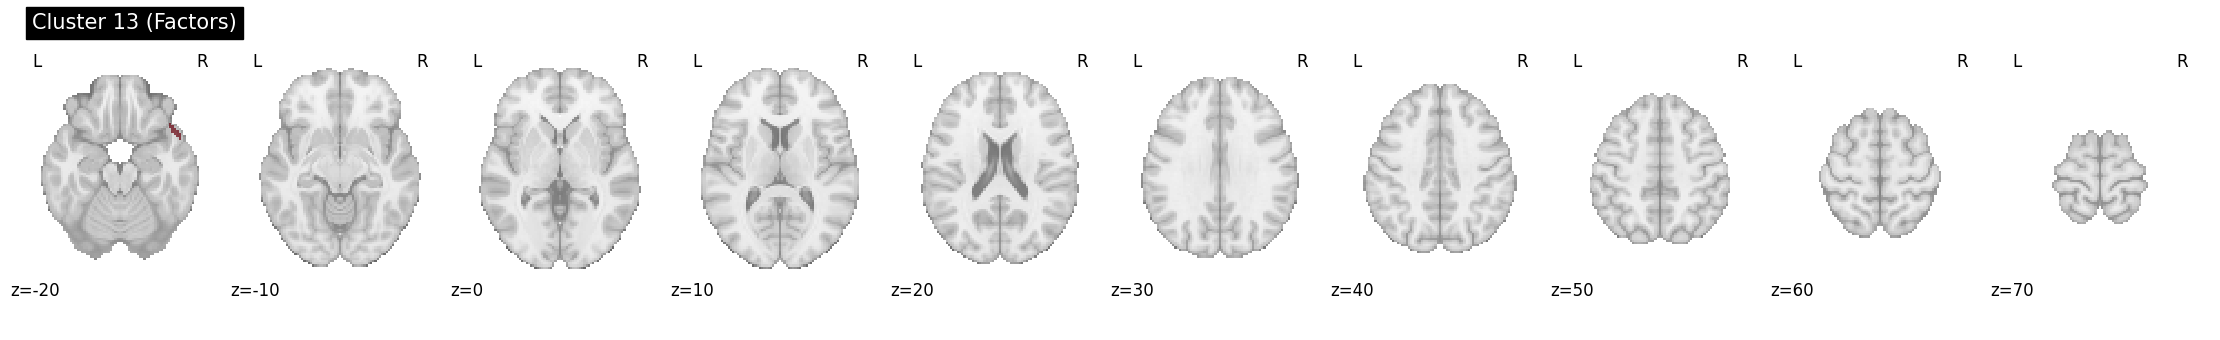

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

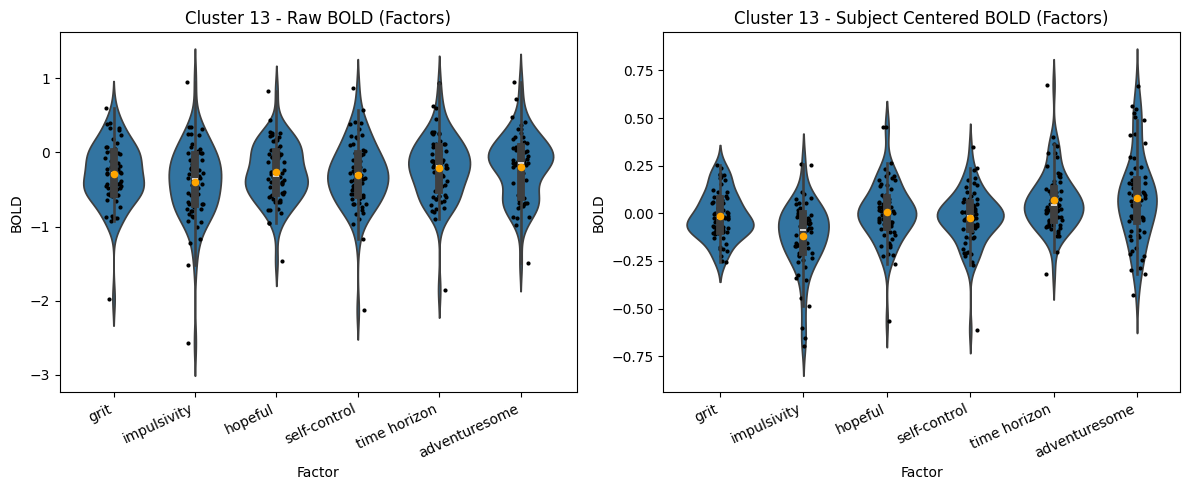

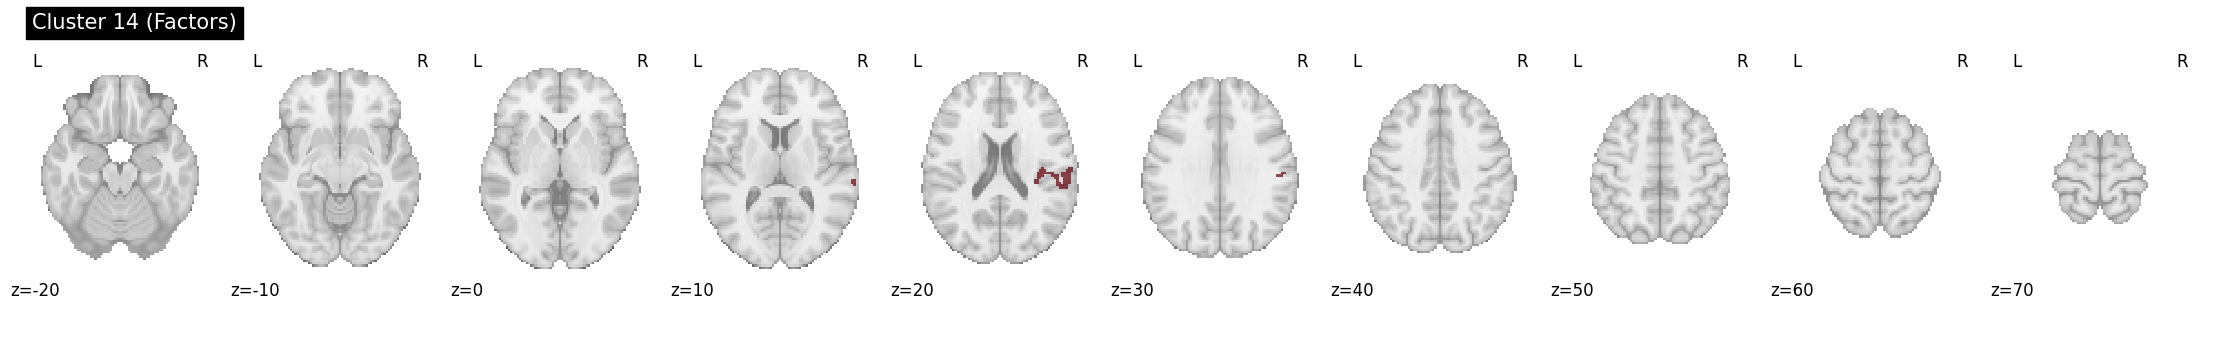

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

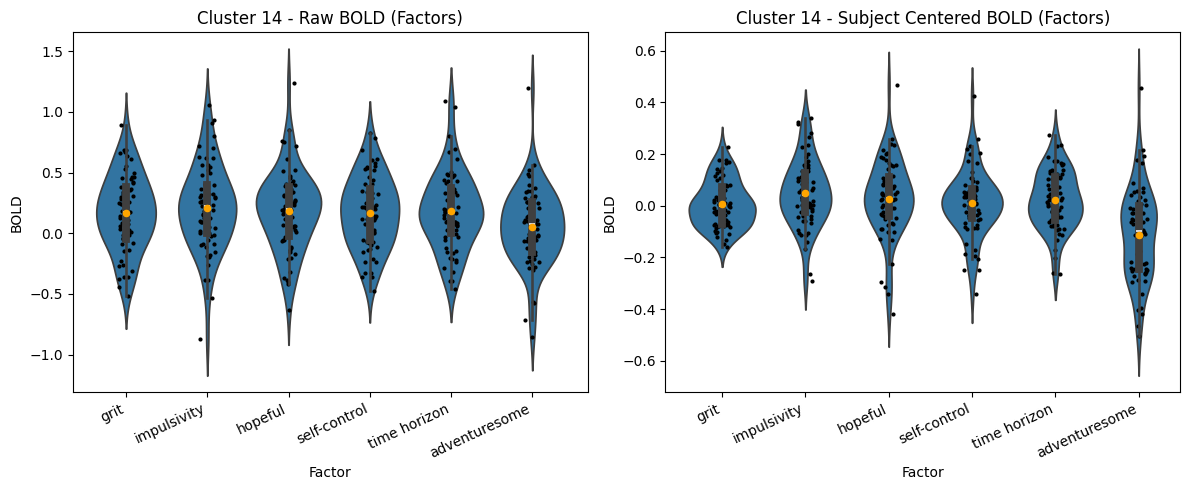

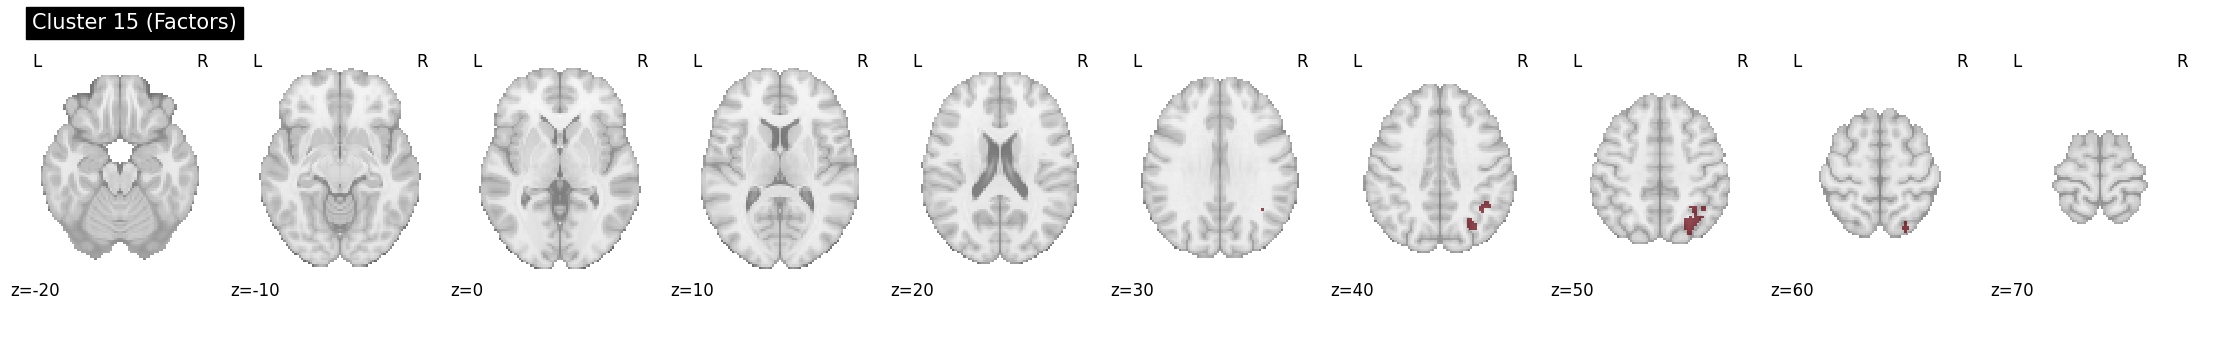

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

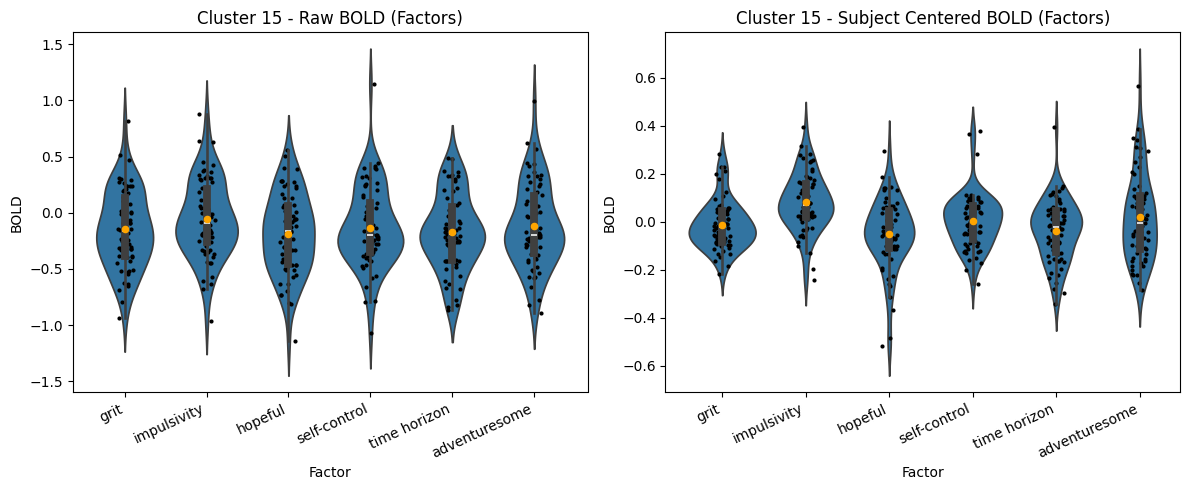

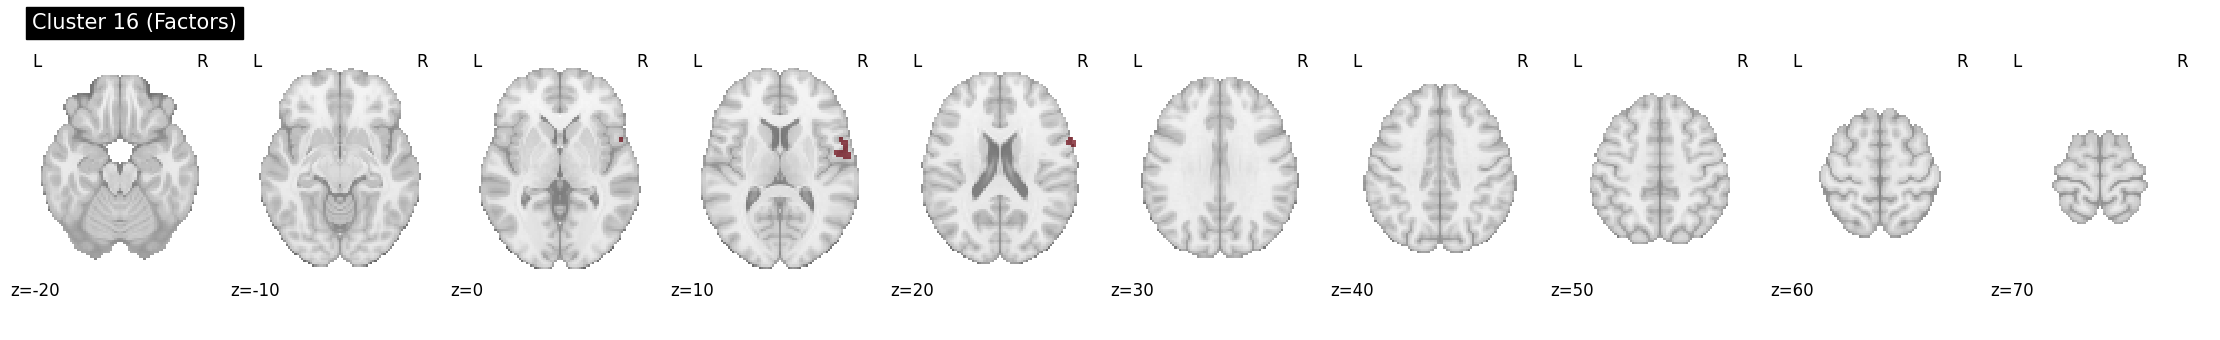

/tmp/ipykernel_6168/1549368057.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
/tmp/ipykernel_6168/1549368057.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
/tmp/ipykernel_6168/1549368057.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].ge

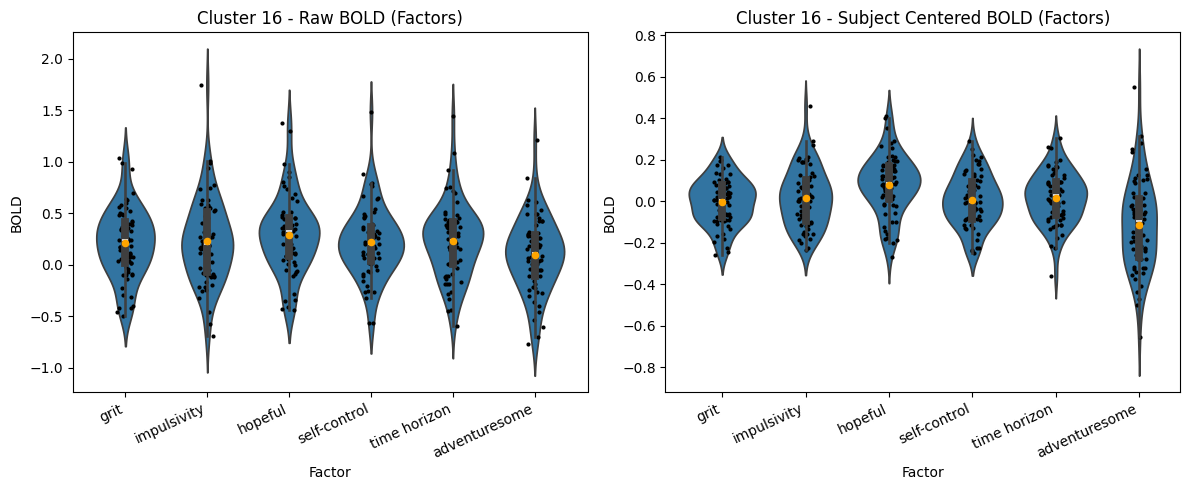

In [9]:
# Step 4: Center within-subject BOLD signals (per cluster)
subject_centered_bold_by_cluster = np.empty_like(bold_by_cluster)
unique_subjects = np.unique(subject_ids)

for subj in unique_subjects:
    idx = np.where(subject_ids == subj)[0]
    subj_data = bold_by_cluster[idx, :]
    subj_mean = subj_data.mean(axis=0, keepdims=True)
    subject_centered_bold_by_cluster[idx, :] = subj_data - subj_mean

# Step 5: Prepare consistent slices for cluster plotting
z_slices = [-20, -10, 0, 10, 20, 30, 40, 50, 60, 70]

# Plotting loop
for cluster_idx, cluster_label in enumerate(cluster_labels):
    # Create nifti image for cluster mask only
    cluster_mask_only = (cluster_data == cluster_label).astype(np.int16)
    cluster_img_only = nib.Nifti1Image(cluster_mask_only, cluster_img.affine)
    # nib.save(cluster_img_only, f"/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/output_surveyMedley_noderivs_rerun/factor_f_test_output/cluster_{int(cluster_label)}.nii.gz")

    # Plot cluster using nilearn with fixed slices
    display = plotting.plot_roi(
        cluster_img_only,
        title=f'Cluster {int(cluster_label)} (Factors)',
        display_mode='z',
        cut_coords=z_slices,
        cmap='Reds',
        alpha=0.7,
        draw_cross=False, 
        vmin=0.0, 
        vmax=1.0
    )
    plotting.show()

    # Create DataFrames for plotting
    df_raw = pd.DataFrame({
        "Factor": factors,
        "BOLD": bold_by_cluster[:, cluster_idx]
    })
    df_raw_mean = df_raw.groupby("Factor")["BOLD"].mean()
    df_raw_mean = df_raw_mean.reset_index()

    df_centered = pd.DataFrame({
        "Factor": factors,
        "BOLD": subject_centered_bold_by_cluster[:, cluster_idx]
    })
    df_centered_mean = df_centered.groupby("Factor")["BOLD"].mean()
    df_centered_mean = df_centered_mean.reset_index()

    # Plot violin plots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    sns.violinplot(x="Factor", y="BOLD", data=df_raw, ax=axes[0])
    sns.stripplot(x="Factor", y="BOLD", data=df_raw, color='k', size=3, ax=axes[0], jitter=True, zorder=1)
    df_raw_mean.plot(x="Factor", y="BOLD", kind="scatter", ax=axes[0], color='orange', zorder=10)
    axes[0].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
    axes[0].set_title(f"Cluster {int(cluster_label)} - Raw BOLD (Factors)")

    sns.violinplot(x="Factor", y="BOLD", data=df_centered, ax=axes[1])
    sns.stripplot(x="Factor", y="BOLD", data=df_centered, color='k', size=3, ax=axes[1], jitter=True, zorder=1)
    df_centered_mean.plot(x="Factor", y="BOLD", kind="scatter", ax=axes[1], color='orange', zorder=10)
    axes[1].set_xticklabels(["grit", "impulsivity", "hopeful", "self-control", "time horizon", "adventuresome"])
    axes[1].set_title(f"Cluster {int(cluster_label)} - Subject Centered BOLD (Factors)")

    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha="right")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=25, ha="right")

    plt.tight_layout()
    plt.show()